# Flag EOA that have less than 30 tx and a bot behavior

In [59]:
import os
from pathlib import Path
import numpy as np
import requests
import pandas as pd
import json

In [60]:
import raphtory as rp
import raphtory.export as ex
import matplotlib.pyplot as plt
import networkx as nx

from raphtory import Graph
import pandas as pd

In [61]:
from sbscorer.sblegos.TransactionAnalyser import TransactionAnalyser as txa

In [62]:
# Set path to data folder
current_dir = Path(os.getcwd())
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
GRANT_ROUND_ID = '0x984e29dCB4286c2D9cbAA2c238AfDd8A191Eefbc'
ODC_DATA_DIR = os.path.join(current_dir.parent.parent.parent, 'data')

PATH_TO_VOTES = os.path.join(DATA_DIR_GITCOIN, 'citizen-votes.csv')
# PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
# PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")

In [63]:
FOLDER_NAME = 'gr18'
CHAIN = 'optimism'
extract_all = True

# Set path to data folder
current_dir = Path(os.getcwd())
PATH_TO_EXPORT = os.path.join(current_dir.parent.parent, 'tx_data', FOLDER_NAME)
PATH_TO_GR18 = os.path.join(current_dir.parent.parent, FOLDER_NAME)
voter_tx_file_name = 'gg18_votes.csv'
passport_file_name = 'gg18_voter_passports.csv'

tx_file_name = 'gr_18_optimism_all_tx.csv'
token_transfer_file_name = 'gr_18_optimism_TOKEN_TRANSFERS.csv'

In [64]:
votes = pd.read_csv(os.path.join(PATH_TO_GR18, voter_tx_file_name))
passports = pd.read_csv(os.path.join(PATH_TO_GR18, passport_file_name))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_29160\1560736169.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv(os.path.join(PATH_TO_GR18, voter_tx_file_name))


In [65]:
CONTRACT_CREATION_AD_NAME = '0x_contract_creation'

df_tx = pd.read_csv(os.path.join(PATH_TO_EXPORT, tx_file_name))

df_tx.loc[df_tx['to_address'].isna(), 'to_address'] = CONTRACT_CREATION_AD_NAME

In [66]:
df_token_transfers = pd.read_csv(os.path.join(PATH_TO_EXPORT, token_transfer_file_name))

C:\Users\DELL Admin\AppData\Local\Temp\ipykernel_29160\3861798164.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_token_transfers = pd.read_csv(os.path.join(PATH_TO_EXPORT, token_transfer_file_name))


In [67]:
unique_address = np.unique(np.concatenate((df_tx['from_address'].values, df_tx['to_address'].values)))

In [68]:
df_token_transfers.columns

Index(['tx_hash', 'block_timestamp', 'contract_address', 'origin_from_address',
       'origin_to_address', 'from_address', 'to_address', 'symbol',
       'raw_amount', 'amount_usd', '__row_index'],
      dtype='object')

In [69]:
len(unique_address)

140258

In [70]:
df_token_transfers_target = df_token_transfers.loc[np.logical_or(df_token_transfers['origin_from_address'].isin(unique_address), df_token_transfers['to_address'].isin(unique_address))]

In [71]:
df_token_transfers_target.shape

(10663360, 11)

In [72]:
df_token_transfers_target.dtypes

tx_hash                 object
block_timestamp         object
contract_address        object
origin_from_address     object
origin_to_address       object
from_address            object
to_address              object
symbol                  object
raw_amount              object
amount_usd             float64
__row_index              int64
dtype: object

In [35]:
# preprocessing remove nan values
df_token_transfers_target.loc[df_token_transfers_target['origin_to_address'].isna(), 'origin_to_address'] = CONTRACT_CREATION_AD_NAME
df_token_transfers_target.loc[df_token_transfers_target['symbol'].isna(), 'symbol'] = ''
df_token_transfers_target.loc[df_token_transfers_target['amount_usd'].isna(), 'amount_usd'] = 0

# preprocessing convert to types
df_token_transfers_target["block_timestamp"] = pd.to_datetime(df_token_transfers_target["block_timestamp"])

column_types = {
    "origin_from_address": str,
    "origin_to_address": str,
    "to_address": str,
    "from_address": str,
    "tx_hash": str,
    "symbol": str,
    "contract_address": str,
    "amount_usd": float
}

df_token_transfers_target = df_token_transfers_target.astype(column_types)


# verify nan values
df_token_transfers_target.isna().sum()

tx_hash                0
block_timestamp        0
contract_address       0
origin_from_address    0
origin_to_address      0
from_address           0
to_address             0
symbol                 0
raw_amount             0
amount_usd             0
__row_index            0
dtype: int64

In [36]:
print(f'shape normal transactions: {df_tx.shape}')
print(f'shape token transfers: {df_token_transfers_target.shape}')

shape normal transactions: (6894506, 9)
shape token transfers: (10663360, 11)


In [37]:
df_tx.isna().sum()

tx_hash            0
block_timestamp    0
from_address       0
to_address         0
gas_limit          0
gas_used           0
tx_fee             0
eth_value          0
__row_index        0
dtype: int64

In [38]:
df_tx.columns

Index(['tx_hash', 'block_timestamp', 'from_address', 'to_address', 'gas_limit',
       'gas_used', 'tx_fee', 'eth_value', '__row_index'],
      dtype='object')

In [39]:
df_tx.dtypes

tx_hash             object
block_timestamp     object
from_address        object
to_address          object
gas_limit            int64
gas_used             int64
tx_fee             float64
eth_value          float64
__row_index          int64
dtype: object

In [41]:
# Convert block_timestamp to datetime with specific format
df_tx["block_timestamp"] = pd.to_datetime(df_tx["block_timestamp"])

column_types = {
    "from_address": str,
    "to_address": str,
    "tx_hash": str,
}

df_tx = df_tx.astype(column_types)


In [54]:
df_tx.dtypes

tx_hash                         object
block_timestamp    datetime64[ms, UTC]
from_address                    object
to_address                      object
gas_limit                        int64
gas_used                         int64
tx_fee                         float64
eth_value                      float64
__row_index                      int64
dtype: object

In [82]:
g = Graph.load_from_pandas(
    edges_df=df_tx,
    src="from_address",
    dst="to_address",
    time="block_timestamp",
    props=["tx_hash", "gas_limit", "gas_used", "tx_fee", "eth_value"],
    layer="normal_transaction",
)

print("The transaction graph:")
print(g)
print(g.vertex("0xf4af0314a06ea7376da5bdecc33f6f9800f1ae28"))

The transaction graph:
Graph(number_of_edges=2320668, number_of_vertices=140258, number_of_temporal_edges=6894506, earliest_time="1636683861000000000", latest_time="1693485791000000000")
Vertex(name=0xf4af0314a06ea7376da5bdecc33f6f9800f1ae28, earliest_time="1688677145000000000", latest_time="1693341547000000000", properties={_id: 0xf4af0314a06ea7376da5bdecc33f6f9800f1ae28})


In [87]:
for index, row in df_tx.iterrows():
    g_token.add_edge(
        src=row["from_address"],
        dst=row["to_address"],
        timestamp=row["block_timestamp"],
        properties={
            "tx_hash": row["tx_hash"],
            "gas_limit": row["gas_limit"],
            "gas_used": row["gas_used"],
            "tx_fee": row["tx_fee"],
            "eth_value": row["eth_value"]},
        layer="token_transfer"
    )

TypeError: argument 'timestamp': time '2023-08-24 20:22:03+00:00' must be a str, dt or an integer

In [44]:
print(f'Number of vertices: {g.num_vertices()}')
print(f'Number of edges: {g.num_edges()}')

Number of vertices: 140258
Number of edges: 2320668


In [45]:
df_token_transfers_target.columns

Index(['tx_hash', 'block_timestamp', 'contract_address', 'origin_from_address',
       'origin_to_address', 'from_address', 'to_address', 'symbol',
       'raw_amount', 'amount_usd', '__row_index'],
      dtype='object')

In [86]:
g_token = Graph.load_from_pandas(
    edges_df=df_token_transfers_target[['origin_from_address', 'to_address', 'block_timestamp', 'tx_hash', 'contract_address', 'origin_to_address', 'from_address', 'symbol', 'amount_usd']],
    src="origin_from_address",
    dst="to_address",
    time="block_timestamp",
    props=["tx_hash", "contract_address", "origin_to_address", "from_address", "symbol", "amount_usd"],
    layer_in_df="token_transfer",
)

In [85]:
for index, row in df_token_transfers_target.iterrows():
    g.add_edge(
        src=row["origin_from_address"],
        dst=row["to_address"],
        timestamp=row["block_timestamp"],
        properties={
            "tx_hash": row["tx_hash"],
            "contract_address": row["contract_address"],
            "origin_to_address": row["origin_to_address"],
            "from_address": row["from_address"],
            "symbol": row["symbol"],
            "amount_usd": row["amount_usd"]},
        layer="token_transfer"
    )

TypeError: argument 'timestamp': time '2023-08-19 22:02:37+00:00' must be a str, dt or an integer

In [ ]:
print(f'Number of vertices: {g.num_vertices()}')
print(f'Number of edges: {g.num_edges()}')

Number of vertices: 140258
Number of edges: 2320668


In [48]:
from raphtory import algorithms as ralg

density = ralg.directed_graph_density(g)
clustering_coefficient = ralg.global_clustering_coefficient(g)
reciprocity = ralg.global_reciprocity(g)

print(f"The graph's density is {density}")
print(f"The graph's clustering coefficient is {clustering_coefficient}")
print(f"The graph's reciprocity is {reciprocity}")

The graph's density is 0.00011796707985922694
The graph's clustering coefficient is 0.00014594744104434759
The graph's reciprocity is 0.024489408761862057


In [49]:
results = ralg.pagerank(g)

# Getting the results for an individual character (Gandalf)
gandalf_rank = results.get("Gandalf")
print(f"Gandalf's ranking is {gandalf_rank}\n")

# Getting the top 5 most important characters and printing out their scores
top_5 = results.top_k(5)
for rank, (name, score) in enumerate(top_5, 1):
    print(f"Rank {rank}: {name} with a score of {score:.5f}")

Gandalf's ranking is None

Rank 1: 0x15fa08599eb017f89c1712d0fe76138899fdb9db with a score of 0.03937
Rank 2: 0x7f5c764cbc14f9669b88837ca1490cca17c31607 with a score of 0.00694
Rank 3: 0xb49c4e680174e331cb0a7ff3ab58afc9738d5f8b with a score of 0.00564
Rank 4: 0xb0d502e938ed5f4df2e681fe6e419ff29631d62b with a score of 0.00451
Rank 5: 0x2e42f214467f647fe687fd9a2bf3baddfa737465 with a score of 0.00450


ModuleNotFoundError: No module named 'scipy'

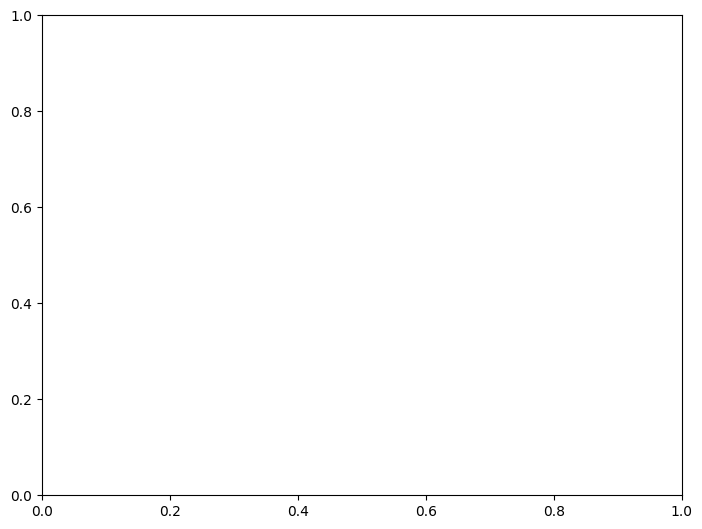

In [ ]:
nx_g = ex.to_networkx(g)
nx.draw(nx_g, with_labels=True, node_color="lightblue", edge_color="gray")